In [1]:
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [25]:
def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y-%H_%M_%S")
    filename = 'submission_' + date + '.csv'

    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)

    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')

def stemlematizer(df):
    """ Function to reduce the words to their root
    """
    lemmer=WordNetLemmatizer()
    stemmer = SnowballStemmer('english')

    new_corpus1 = [' '.join([stemmer.stem(word) for word in tweet.split(' ')]) for tweet in df.text.values]
    new_corpus = [' '.join([lemmer.lemmatize(word) for word in tweet.split(' ')]) for tweet in new_corpus1] 
    
    df.text = new_corpus
    return df



def load_and_train(dataframe, trainmodelclassifier, test=None, *model_args, **model_kwargs ):

# If there is no test data, split the input
    if test is None:
        train, test = train_test_split(dataframe, test_size=0.15)
    else:
        train = dataframe

    dataframe.airline_sentiment = pd.Categorical(dataframe.airline_sentiment)
    
    x_train = train['text']
    y_train = train['airline_sentiment']
    
    x_test = test['text']
    #we build the classifier, that has everything inside:
    text_clf = Pipeline([('vect', CountVectorizer(min_df=1,
                                              stop_words='english', ngram_range=(1,2), 
                                              analyzer='word', token_pattern=r'[^@|^#]\b\w+\b')),
                     ('tfidf', TfidfTransformer(norm='l2')),
                     ('clf', trainmodelclassifier(*model_args, **model_kwargs))])

    

# SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))])

    text_clf.fit(x_train, y_train)
    predicted = text_clf.predict(x_test)

    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
   
    try:
        acc = accuracy_score(test.airline_sentiment, predicted)
        print('accuracy_score = ', acc)
    except:
        print('No accuracy computed beacuse there is NO test target')
        acc = None
    return predicted, x_train, y_train, x_test, y_test, acc


In [23]:
df = pd.read_csv('tweets_public.csv', index_col='tweet_id')
df_submission = pd.read_csv('tweets_submission.csv', index_col='tweet_id')

In [24]:
df = stemlematizer(df)
df_submission = stemlematizer(df_submission)

In [26]:
# Using a SGDClassifier: it fits a linear support vector machine (SVM) 
predicted, x_train, y_train, x_test, y_test, acc = load_and_train(df, SGDClassifier, test=None, penalty='elasticnet', max_iter=10)
#create_submit_file(df_submission, predicted)


accuracy_score =  0.805007587253


classification accuracy: 0.805007587253


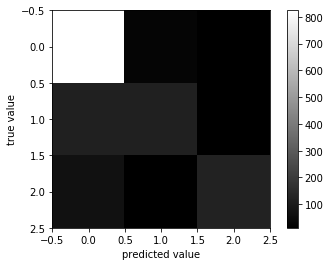

             precision    recall  f1-score   support

   negative       0.82      0.95      0.88       867
    neutral       0.72      0.47      0.57       246
   positive       0.82      0.60      0.69       205

avg / total       0.80      0.81      0.79      1318



In [27]:
def plot_confusion_matrix(y, y_pred):
    plt.imshow(metrics.confusion_matrix(y, y_pred),
               cmap=plt.cm.gray, interpolation='nearest')
    plt.colorbar()
    plt.ylabel('true value')
    plt.xlabel('predicted value')
    plt.show()
    
print ("classification accuracy:", metrics.accuracy_score(y_test, predicted))
plot_confusion_matrix(y_test, predicted)
print(metrics.classification_report(y_test,predicted))

This is to try to improve the training by searching which training subset gives best score (since each training subset is selected randomly). Just for fun:

In [191]:
while True:
    predicted, x_train, y_train, acc = load_and_train(df, SGDClassifier, test=None, penalty='elasticnet', max_iter=10)
    if acc > 0.8:
        print(acc)
        break

0.803490136571


In [185]:
text_clf = Pipeline([('vect', CountVectorizer(min_df=1,
                                              stop_words='english', ngram_range=(1,2), 
                                              analyzer='word', token_pattern=r'[^@]\b\w+\b')),
                     ('tfidf', TfidfTransformer(norm='l2')),
                     ('clf', SGDClassifier(penalty='elasticnet', max_iter=10))])

x_test = df_submission['text']
text_clf.fit(x_train, y_train)
predicted = text_clf.predict(x_test)

create_submit_file(df_submission, predicted)

Submission file created: submission_02_04_2018-14_01_34.csv
Upload it to Kaggle InClass


I have created this function to load the data in a dictionary form:

In [78]:
from textblob.classifiers import NaiveBayesClassifier

def load_and_divide(dataframe, test=None):

# If there is no test data, split the input
    if test is None:
        train, test = train_test_split(dataframe, test_size=0.15)
    else:
        train = dataframe

    dataframe.airline_sentiment = pd.Categorical(dataframe.airline_sentiment)
    
    x_train = train['text']
    y_train = train['airline_sentiment']
    
    x_test = test['text']
    
    try:
        y_test = test['airline_sentiment']
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
        
    return {
        'train': {
            'x': x_train,
            'y': y_train
        },
        'test': {
            'x': x_test,
            'y': y_test
        }
    }

In [79]:
data = load_and_divide(df)

I tried this example from the DataCleaning notebook, using textblob, but the overall accuracy is not better than the other approach that I used, and the process is extremely slower that the other. **Discarded for the moment.**

In [80]:
dataset_list = []
for i in np.arange(len(data['train']['x'])):
    data_tuple = (data['train']['x'].iloc[i], data['train']['y'].iloc[i])
    dataset_list.append(data_tuple)

dataset_test_list = []
for i in np.arange(len(data['test']['x'])):
    data_tuple = (data['test']['x'].iloc[i], data['test']['y'].iloc[i])
    dataset_test_list.append(data_tuple)


In [81]:
cl = NaiveBayesClassifier(dataset_list)

In [82]:
cl.accuracy(dataset_test_list)

0.8050075872534143